In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, confusion_matrix, classification_report
from tqdm import tqdm

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
df = pd.read_parquet('E:/Phat/imbalance/data_electricity_processing.parquet')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22178305 entries, 0 to 22178304
Data columns (total 90 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   ma_dviqly                   int32  
 1   id_chiso                    float32
 2   id_bcs                      float32
 3   ma_dvictren                 int32  
 4   ma_ddo                      int32  
 5   bcs_chiso                   int32  
 6   hs_nhan                     float32
 7   so_cto_chiso                float32
 8   ky                          int32  
 9   thang                       int32  
 10  nam                         int32  
 11  chiso_cu                    float32
 12  chiso_moi                   float32
 13  san_luong                   float32
 14  sluong_ttiep                float32
 15  sluong_trphu                float32
 16  loai_chiso                  int32  
 17  thd_le                      float32
 18  ma_ttcto                    int32  
 19  sluong_1           

In [12]:
target = 'fraud'
X = df.drop(columns=[target])
y = df[target]


X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

[Text(0, 0.5, '4379498'), Text(0, 0.5, '56163')]

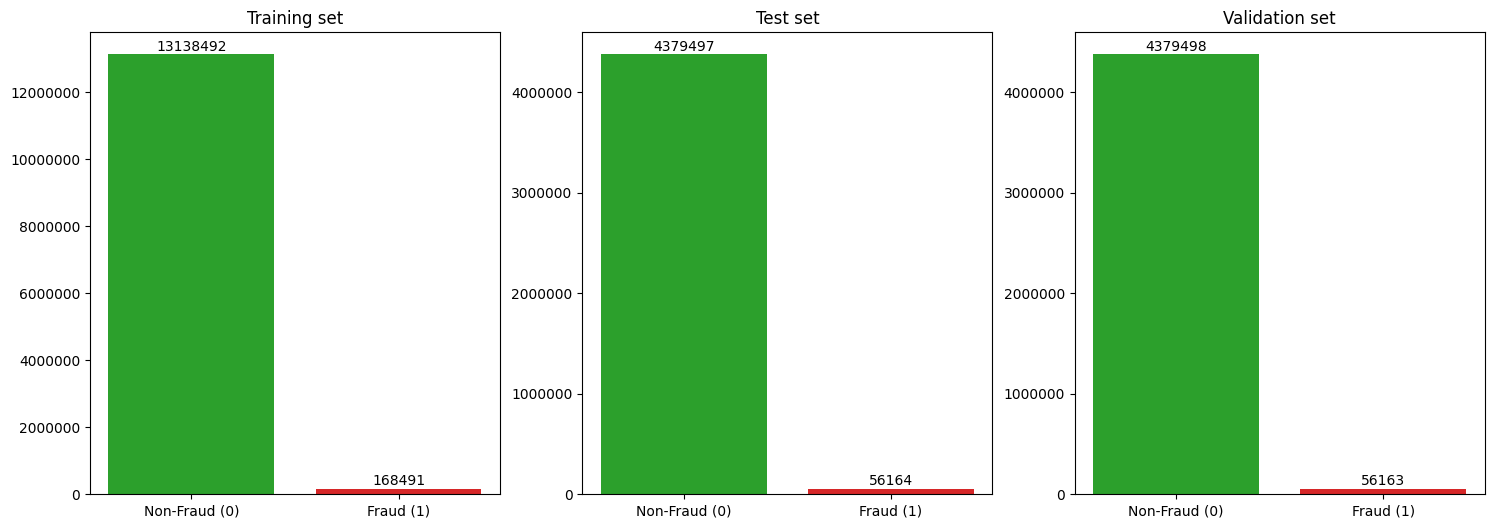

In [14]:
import matplotlib.pyplot as plt

# Tinh so luong  fraud va nonfraud trong 3 tap train, test va validation
non_fraud_train, fraud_train = y_train.value_counts()
non_fraud_test, fraud_test = y_test.value_counts()
non_fraud_valid, fraud_valid = y_val.value_counts()

# Ve bieu do bar chart the hien so luong fraud va non fraud
x = ['Non-Fraud (0)', 'Fraud (1)']
y1 = [non_fraud_train, fraud_train]
y2 = [non_fraud_test, fraud_test]
y3 = [non_fraud_valid, fraud_valid]
bar_color = ['tab:green','tab:red']

fig, axs = plt.subplots(1,3, figsize=(18,6))

bar1 = axs[0].bar(x, y1, color=bar_color)
axs[0].set_title('Training set')
axs[0].ticklabel_format(style='plain', axis='y')
axs[0].bar_label(bar1, padding= 0.5, fmt = '{:.0f}')

bar2 = axs[1].bar(x, y2, color=bar_color)
axs[1].set_title('Test set')
axs[1].ticklabel_format(style='plain', axis='y')
axs[1].bar_label(bar2, padding= 0.5, fmt = '{:.0f}')

bar3 = axs[2].bar(x, y3, color=bar_color)
axs[2].set_title('Validation set')
axs[2].ticklabel_format(style='plain', axis='y')
axs[2].bar_label(bar3, padding= 0.5, fmt = '{:.0f}')



In [15]:
# Tính tỉ lệ lớp Fraud trong tập train và test
train_ratio = y_train.mean()
test_ratio = y_test.mean()

print(f"Tỉ lệ Fraud trong tập TRAIN: {train_ratio:.4f} ({train_ratio*100:.2f}%)")
print(f"Tỉ lệ Fraud trong tập TEST:  {test_ratio:.4f} ({test_ratio*100:.2f}%)")

Tỉ lệ Fraud trong tập TRAIN: 0.0127 (1.27%)
Tỉ lệ Fraud trong tập TEST:  0.0127 (1.27%)


In [16]:
# Tính tỷ lệ lớp trong tập huấn luyện và tập kiểm tra
train_class_distribution = y_train.value_counts(normalize=True)
test_class_distribution = y_test.value_counts(normalize=True)

print("Tỉ lệ các lớp trong tập TRAIN:")
print(train_class_distribution)
print("\nTỉ lệ các lớp trong tập TEST:")
print(test_class_distribution)


Tỉ lệ các lớp trong tập TRAIN:
fraud
0    0.987338
1    0.012662
Name: proportion, dtype: float64

Tỉ lệ các lớp trong tập TEST:
fraud
0    0.987338
1    0.012662
Name: proportion, dtype: float64


In [17]:
# Đếm số lượng mẫu mỗi lớp trong tập train, val và test
def count_class_distribution(y, name=""):
    fraud_count = (y == 1).sum()
    nonfraud_count = (y == 0).sum()
    print(f"{name} set:")
    print(f"  Fraud     (1): {fraud_count}")
    print(f"  Non-Fraud (0): {nonfraud_count}")
    print("-" * 40)

count_class_distribution(y_train, "TRAIN")
count_class_distribution(y_val, "VALIDATION")
count_class_distribution(y_test, "TEST")


TRAIN set:
  Fraud     (1): 168491
  Non-Fraud (0): 13138492
----------------------------------------
VALIDATION set:
  Fraud     (1): 56163
  Non-Fraud (0): 4379498
----------------------------------------
TEST set:
  Fraud     (1): 56164
  Non-Fraud (0): 4379497
----------------------------------------


# CatBoost

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin


# Tao custom metrix
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

In [24]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

SEED = 42
cb_params = {
    'loss_function': 'Logloss',
    'iterations': 250,
    'learning_rate': 0.06936,
    'max_depth': 7,
    'l2_leaf_reg': 6.216,
    'subsample': 0.625,
    'min_data_in_leaf': 24,
    'random_state': 42,
    'verbose': False
}

# Chuẩn bị dữ liệu
X = X_temp
y = y_temp

# Khởi tạo mô hình CatBoost với các siêu tham số tốt nhất
model = CatBoostClassifier()


# Huấn luyện mô hình cuối cùng trên toàn bộ dữ liệu
print("Training final model on the entire combined dataset...")
model.fit(X, y)

Training final model on the entire combined dataset...
Learning rate set to 0.5
0:	learn: 0.0620068	total: 3.35s	remaining: 55m 48s
1:	learn: 0.0211888	total: 6.48s	remaining: 53m 53s
2:	learn: 0.0157159	total: 9.64s	remaining: 53m 24s
3:	learn: 0.0113995	total: 13.4s	remaining: 55m 25s
4:	learn: 0.0090688	total: 16.4s	remaining: 54m 28s
5:	learn: 0.0079574	total: 18.9s	remaining: 52m 13s
6:	learn: 0.0073312	total: 21.5s	remaining: 50m 56s
7:	learn: 0.0064297	total: 24.8s	remaining: 51m 20s
8:	learn: 0.0058601	total: 28.4s	remaining: 52m 7s
9:	learn: 0.0055164	total: 30.9s	remaining: 51m
10:	learn: 0.0051346	total: 33.1s	remaining: 49m 39s
11:	learn: 0.0048265	total: 36.2s	remaining: 49m 39s
12:	learn: 0.0045516	total: 38.9s	remaining: 49m 9s
13:	learn: 0.0044506	total: 41.5s	remaining: 48m 39s
14:	learn: 0.0041975	total: 44.6s	remaining: 48m 47s
15:	learn: 0.0039797	total: 47.2s	remaining: 48m 23s
16:	learn: 0.0038026	total: 49.9s	remaining: 48m 6s
17:	learn: 0.0037379	total: 52.7s	re

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4379497
           1       1.00      1.00      1.00     56164

    accuracy                           1.00   4435661
   macro avg       1.00      1.00      1.00   4435661
weighted avg       1.00      1.00      1.00   4435661



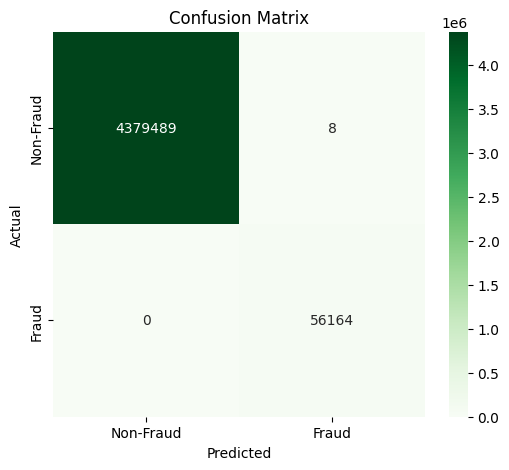

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Đánh giá mô hình với classification report và confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Vẽ confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [27]:
# Định nghĩa độ đo tùy chỉnh (Partial AUC)
def custom_metric(y_true, y_pred_proba):
    min_tpr = 0.80  # Ngưỡng TPR tối thiểu
    max_fpr = abs(1 - min_tpr)  # Ngưỡng FPR tối đa
    
    v_gt = abs(y_true - 1)  # Chuyển đổi y_true thành lớp tích cực (1) và lớp tiêu cực (0)
    v_pred = np.array([1.0 - x for x in y_pred_proba])  # Chuyển đổi xác suất dự đoán thành lớp tiêu cực
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)  # Tính AUC của phần có FPR giới hạn
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)  # Điều chỉnh AUC

    return partial_auc

# Lấy xác suất dự đoán của lớp tích cực (Fraud)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Dự đoán xác suất lớp tích cực (Fraud)

# Tính độ đo tùy chỉnh trên tập test
custom_auc_score = custom_metric(y_test, y_pred_proba)

# In kết quả độ đo tùy chỉnh
print(f'Custom pAUC Score: {custom_auc_score}')
print(f'AUC Score: {roc_auc_score(y_test, y_pred_proba)}')

Custom pAUC Score: 0.19999999954466002
AUC Score: 0.99999999954466


C:\Users\HOME\AppData\Local\Temp\ipykernel_8404\4278273687.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


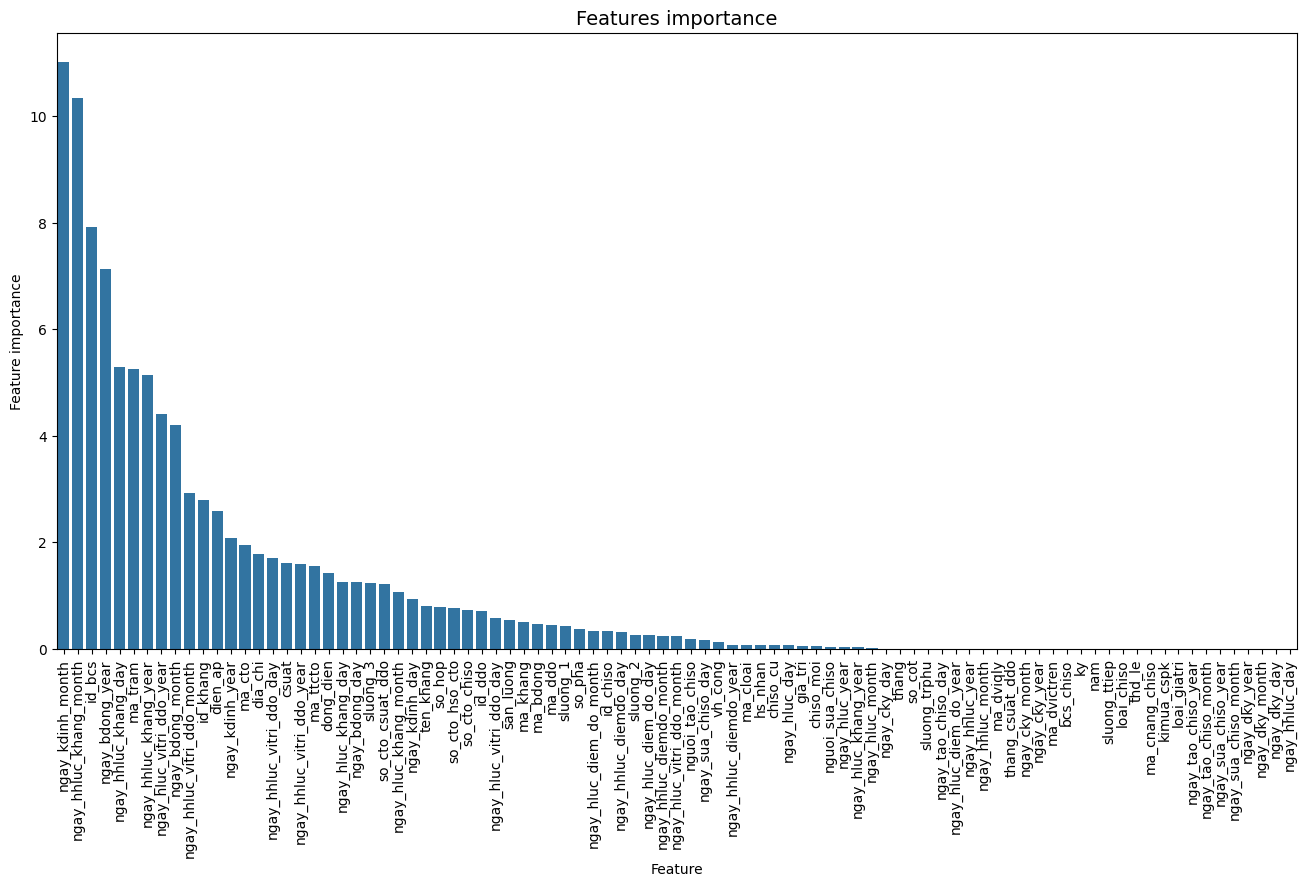

In [29]:
Features = [col for col in df.columns if col != target]
tmp = pd.DataFrame({'Feature': Features, 'Feature importance': model.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (16,8))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [8]:
# --- XÁC ĐỊNH index cho các cat_features ---
cat_feature_indices = [X.columns.get_loc(c) for c in cat_cols]

In [9]:
# --- ĐỊNH NGHĨA SMOTENC + TomekLinks ---
smote = SMOTENC(
    categorical_features=cat_feature_indices,
    sampling_strategy=0.07,
    random_state=42
)
smote_tomek = SMOTETomek(
    sampling_strategy=0.07,
    smote=smote,
    random_state=42
)

In [10]:
# --- Custom pAUC function ---
def partial_auc_scorer(y_true, y_pred_proba, max_fpr=0.2):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    mask = fpr <= max_fpr
    fpr_part = np.append(fpr[mask], max_fpr)
    tpr_part = np.append(tpr[mask], np.interp(max_fpr, fpr, tpr))
    p_auc = np.trapz(tpr_part, fpr_part) / max_fpr
    return p_auc

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

# Tao custom metrix
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

In [16]:
cb_params = {
    'loss_function': 'Logloss',
    'iterations': 250,
    'learning_rate': 0.06936,
    'max_depth': 7,
    'l2_leaf_reg': 6.216,
    'subsample': 0.625,
    'min_data_in_leaf': 24,
    'random_state': 42,
    'verbose': False
}

In [17]:
model = CatBoostClassifier(**cb_params)
model.fit(X_train, y_train, cat_features=cat_cols)


CatBoostError: bad allocation

In [20]:
# --- ĐÁNH GIÁ TRÊN TEST SET ---
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

print(f"\nTEST AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
pauc_test = partial_auc_scorer(y_test, y_pred_proba)
print(f"TEST pAUC (FPR<=0.2): {pauc_test:.4f}")


TEST AUC: 1.0000


NameError: name 'partial_auc_scorer' is not defined

In [ ]:
# --- BÁO CÁO KẾT QUẢ ---
print("\nClassification Report on TEST set:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Fraud','Fraud'], 
            yticklabels=['Non-Fraud','Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on TEST Set')
plt.show()

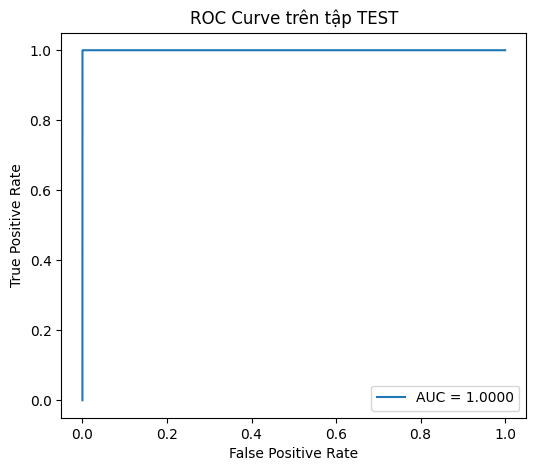

In [21]:
# --- VẼ ROC CURVE ---
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve trên tập TEST')
plt.legend(loc='lower right')
plt.show()